## Step 1: Load and Explore the Dataset

We load the dataset from `Data_ret_pred.xlsx`. The training data is in **Sheet 1**, and the testing data is in **Sheet 2**.

The dataset contains financial and economic predictors, with `ExReturns` as the target variable.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "data/Data_ret_pred.xlsx"
train_data = pd.read_excel(file_path, sheet_name=0)  # Sheet 1 for training
test_data = pd.read_excel(file_path, sheet_name=1)   # Sheet 2 for testing

# Display the first few rows
train_data.head()
    

c:\Users\marwi\miniconda3\envs\ml_for_finance\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,yyyymm,pd,eps,dy,b/m,tbl,CreditSpread,DefaultSpread,lty,ntis,infl,ltr,corpr,svar,ExReturns
0,193705,20.074074,1.419753,0.049300,0.489382,0.0041,0.0151,0.0051,0.0282,0.028278,0.006993,0.0053,0.0040,0.003593,-0.006041
1,193706,18.333333,1.392857,0.051661,0.504961,0.0036,0.0165,0.0043,0.0285,0.031266,0.000000,-0.0018,0.0053,0.002984,-0.054103
2,193707,20.791828,1.453065,0.053030,0.464649,0.0028,0.0166,0.0048,0.0277,0.027225,0.006944,0.0138,0.0039,0.002982,0.098758
3,193708,20.218496,1.516803,0.046722,0.481935,0.0029,0.0168,0.0038,0.0286,0.031064,0.000000,-0.0104,-0.0017,0.002141,-0.051425
4,193709,17.870130,1.584416,0.048005,0.553147,0.0031,0.0188,0.0044,0.0284,0.035847,0.006897,0.0045,0.0025,0.015821,-0.139868


## Step 2: Data Preprocessing

- We separate predictors (`X_train`, `X_test`) and the target variable (`y_train`, `y_test`).
- We standardize the predictors using `StandardScaler`.


In [2]:

# Separate predictors (X) and target variable (y)
X_train = train_data.drop(columns=["yyyymm", "ExReturns"])  # Drop date and target
y_train = train_data["ExReturns"]

X_test = test_data.drop(columns=["yyyymm", "ExReturns"])  # Drop date and target
y_test = test_data["ExReturns"]

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    

## Step 3: Fitting LASSO Regression with Cross-Validation

- We use **LassoCV** to automatically determine the best tuning parameter (`lambda`).



In [3]:

# Fit LASSO with cross-validation to select the best lambda
lasso_cv = LassoCV(cv=10, random_state=0)  # 10-fold CV
lasso_cv.fit(X_train_scaled, y_train)

# Extract the best alpha (lambda) selected
best_lambda = lasso_cv.alpha_

# Print the best lambda value
print(f"Best lambda (α) selected by cross-validation: {best_lambda:.5f}")
    

Best lambda (α) selected by cross-validation: 0.00109


## Step 4: Plotting LASSO Coefficients

- We visualize how LASSO shrinks coefficients as lambda increases.
- The best lambda is marked with a red dashed line.
- The legend shows the feature names from the dataset.


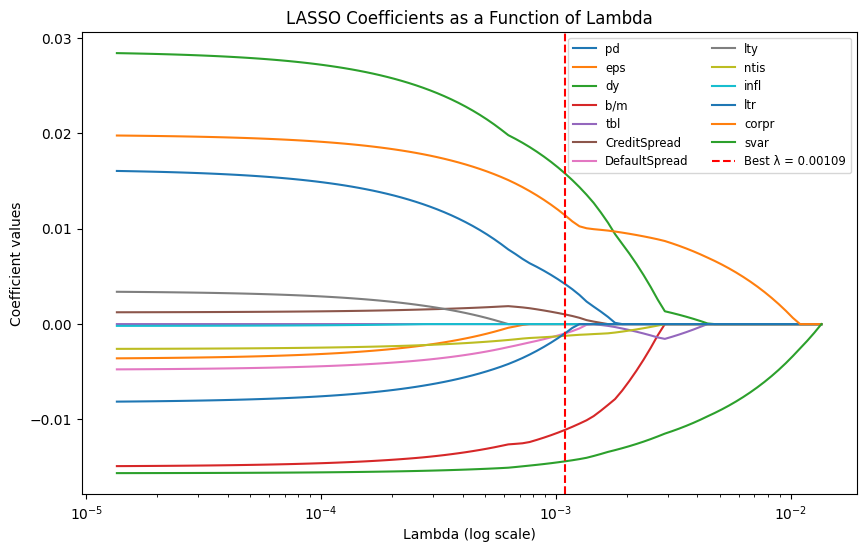

In [4]:

# Plot coefficient paths with proper legend labels
lambdas = lasso_cv.alphas_  # Candidate lambda values
coefs = lasso_cv.path(X_train_scaled, y_train, alphas=lambdas)[1].T  # Coefficients

feature_names = X_train.columns

plt.figure(figsize=(10, 6))
for i, coef in enumerate(coefs.T):
    plt.plot(lambdas, coef, label=feature_names[i])  # Use actual feature names

plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Coefficient values")
plt.title("LASSO Coefficients as a Function of Lambda")
plt.axvline(best_lambda, linestyle="--", color="red", label=f"Best λ = {best_lambda:.5f}")
plt.legend(loc="best", fontsize="small", ncol=2)  # Legend with feature names
plt.show()
    

## Step 5: Evaluating Test Performance (MSE) and Plotting Train and Test MSE vs. Lambda

- We compute the **Mean Squared Error (MSE)** on the test set.
- We also compute MSE for different lambda values.
- The training MSE (green) and test MSE (blue) are plotted against lambda.
- This demonstrates the **bias-variance tradeoff** in LASSO.


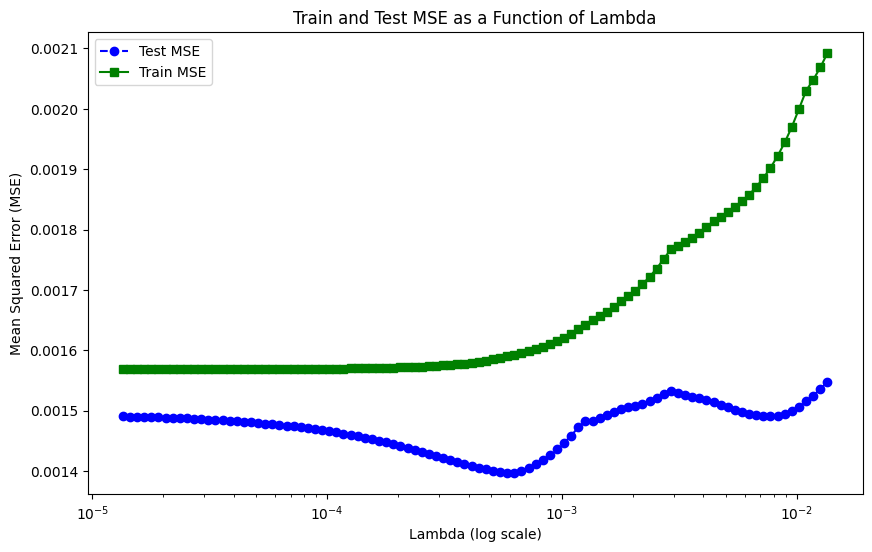

In [5]:

# Compute MSE on the test set
y_pred = lasso_cv.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_pred)

# Compute MSEs across different lambdas (for plotting)
mse_path = [
    mean_squared_error(y_test, LassoCV(alphas=[l], random_state=0).fit(X_train_scaled, y_train).predict(X_test_scaled))
    for l in lambdas
]

# Compute MSE for the training set across different lambdas
mse_train_path = [
    mean_squared_error(y_train, LassoCV(alphas=[l], random_state=0).fit(X_train_scaled, y_train).predict(X_train_scaled))
    for l in lambdas
]

# Plot MSE for training and testing
plt.figure(figsize=(10, 6))
plt.plot(lambdas, mse_path, marker="o", linestyle="--", label="Test MSE", color="blue")
plt.plot(lambdas, mse_train_path, marker="s", linestyle="-", label="Train MSE", color="green")
plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Train and Test MSE as a Function of Lambda")
plt.legend()
plt.show()


    